In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime
import copy
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn import model_selection as ms
from sklearn import linear_model as lm

# Evaluating the performance of pair trading two commodities (Brent Oil and WTI Oil)

##Pair Trading is similar to a mean reversion strategy. Here we assume that the assets should fluctuate around an "equillibrium" spread/difference.

##Consider Google and Apple: This means that if google rockets up in price and Apple doesn't, we expect *over time* **either** Google will come back down or Apple will go up (either way the pair's spread or difference will return back to equillibrium) or **both!**

##Therefore, there will be a combination of the pair of assets that is stationary and mean reverting - the combination doesn't have to be (and often isn't) 1 Google for 1 Apple.

##To understand this strategy in greater detail look here:

##https://hudsonthames.org/definitive-guide-to-pairs-trading/

In [2]:
#Import Data from yfinance

asset_1 = 'CL=F' #Crude Oil
asset_2 = 'BZ=F' #Brent Oil
tickers = [asset_1, asset_2]

start_date = datetime(2007, 1, 1)
end_date = datetime(2020, 1, 1)

data = yf.download(tickers, start=start_date, end=end_date)['Adj Close'].dropna()
train, test = ms.train_test_split(data, shuffle = False, test_size = 0.2)
print(data.head())


[*********************100%%**********************]  2 of 2 completed

                 BZ=F       CL=F
Date                            
2007-07-30  75.739998  76.830002
2007-07-31  77.050003  78.209999
2007-08-01  75.349998  76.529999
2007-08-02  75.760002  76.860001
2007-08-03  74.750000  75.480003


# Plot the train part of the two time series and plot a heatmap / print their correlation (2 Marks)

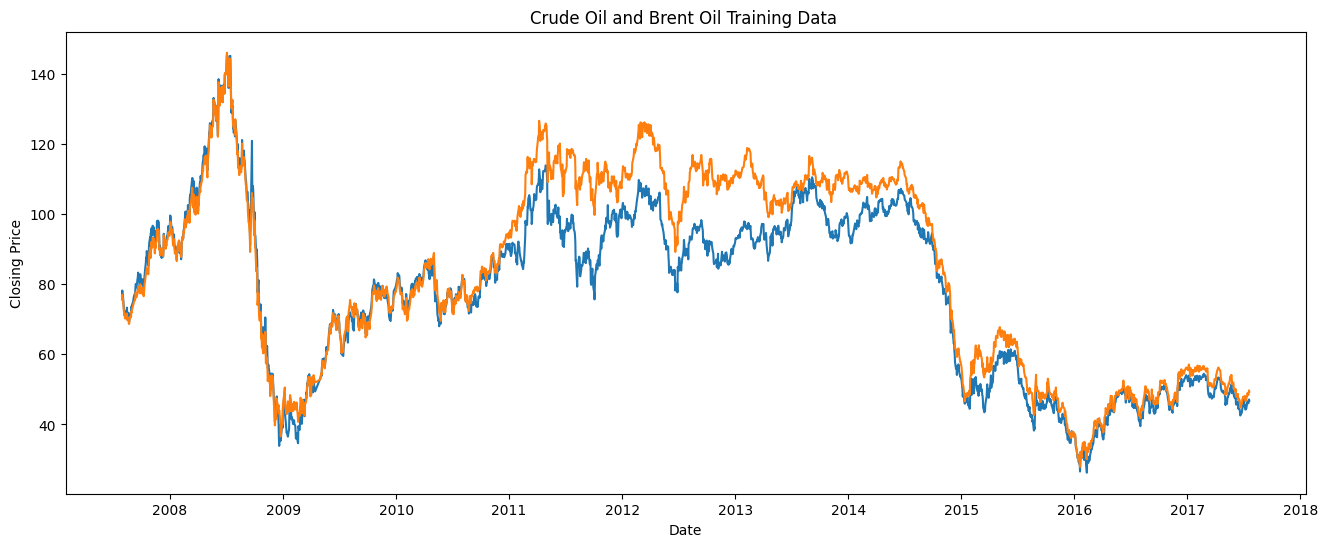

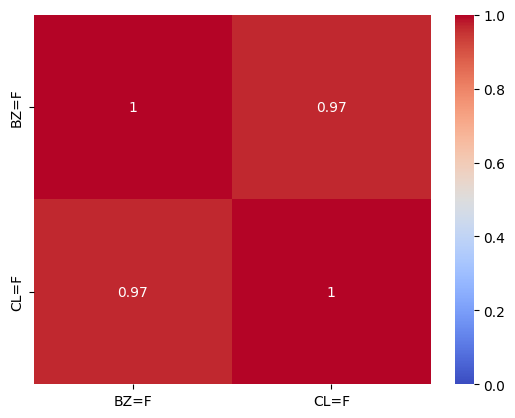

In [3]:
plt.figure(figsize=(16,6))
plt.plot(train[asset_1], label=asset_1)
plt.plot(train[asset_2], label=asset_2)
plt.title("Crude Oil and Brent Oil Training Data ")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.show()


# Linear Regression (2 Marks)

## Plot the value of X against the value of Y - we want to find the sensitivity of Y when X changes by 1 dollar (sometimes called the hedging ratio: https://robotwealth.com/practical-pairs-trading/#:~:text=In%20pairs%20trading%2C%20that%20coefficient,depending%20on%20the%20approach%20taken.)

## We will buy a ratio of gradient X per Y bought so that overall, if they were perfectly linearly related, our overall position would never make or lose any money.

## Regress X against y to find our gradient (hedging ratio) and the intercept. After you've done this update the data below with your values/variables (do not delete the LHS): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

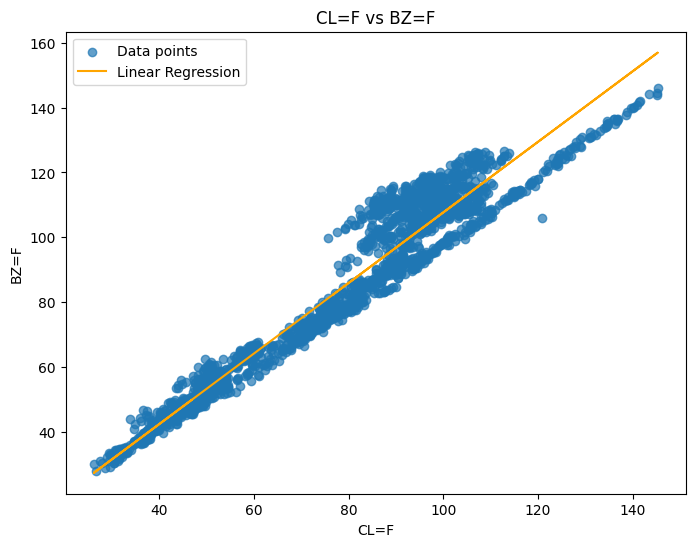

Hedging Ratio:  1.0882


In [4]:
x = train[asset_1].values.reshape(-1, 1)
y = train[asset_2].values.reshape(-1, 1)

model = lm.LinearRegression().fit(x, y)

plt.figure(figsize=(8, 6))
plt.scatter(train[asset_1], train[asset_2], alpha=0.7, label='Data points')
plt.plot(np.array(train[asset_1]), np.array(model.predict(x)),color='orange', label='Linear Regression')
plt.title(f'{asset_1} vs {asset_2}')
plt.xlabel(asset_1)
plt.ylabel(asset_2)
plt.legend()
plt.show()

print(f'Hedging Ratio: ', round(model.coef_[0][0], 4))

In [5]:
#Don't delete/change these variable names just replace the None's
R2_coeff = model.score(x,y)
gradient = model.coef_[0][0]
intercept = model.intercept_[0]

print("R^2 Coefficient: ", R2_coeff)
print("Gradient: ", gradient)
print("Intercept: ", intercept)

R^2 Coefficient:  0.9376630295639481
Gradient:  1.088164912658797
Intercept:  -1.154808522268766


# Compute the Residual (on train) and Plot it (1 mark)

## Given a new value for X and Y, we can now make a prediction of Y based on X using our Linear Regression model, then calculate the residual between our prediction and the actual value.

## Calculating all the residuals for the training data will generate a distribution that will tell us the mean (equilibrium) and std values. This is how we will generate signals later.


## residual = y - pred(Y)
## pred(Y) = m X + c

In [6]:
y_pred = model.predict(x)

residual = y - y_pred

-3.3314824240766602e-15


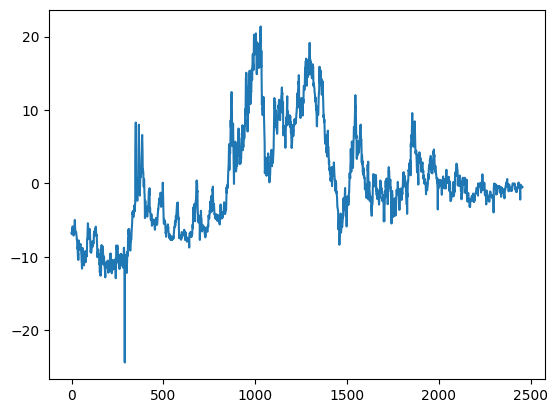

In [7]:
train_residual = residual ##Replace the np.zeros with your computed residual for the train set
print(train_residual.mean())
plt.plot(train_residual)
plt.show()

#Vibe Check - Stationarity Test for the Residual (1 Mark)

## If the pair are truly "cointegrated" then their residue should be stationary. There are a bunch of statistical tests to *investigate* whether the residue is stationary, but a standard one is the augmented dickie fuller (ADF): https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

## Check out the docs and perform the adfuller test with a maxlag of 0. spit out the p-value (note if you can't work this out **unlike the other steps** it won't affect your final results).

In [8]:
test = adfuller(x)

In [9]:
p_value = test[0]
print("P value:", p_value)

P value: -1.7387165863336005


# Convert the (train) residue to a standard normal (mean of 0, std of 1) (1 mark)

## This is always done just as good practice.

## X = (x-mean(x))/std(x)

In [10]:
standardisedResiduals = (residual - np.mean(residual))/np.std(residual)

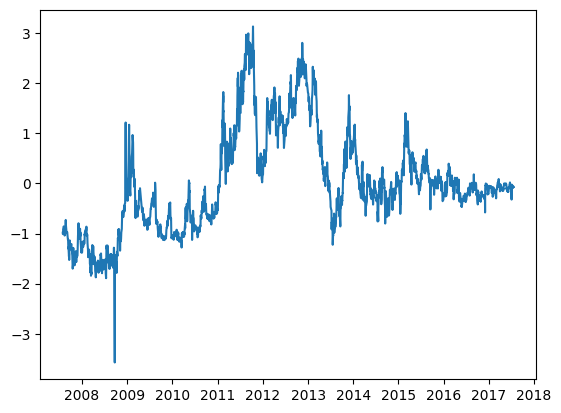

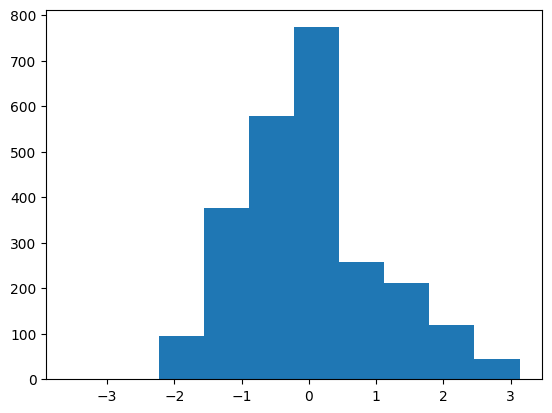

In [11]:
#Insert the normalised train residue below:

train_z_score = standardisedResiduals ##Replace the np.zeros with your variable name

plt.plot(train.index, train_z_score)
plt.show()
plt.hist(train_z_score)
plt.show()

# Signal Weightings

## These are a bit funky, we have 2 signal types.

## **Basic Signal:** One is a simple "whenever the two assets difference is more than 1 sigma away from its historic 'equillibrium', we bet on the residue returning to less than one sigma" (go short or long depending on whether the residue is ±). We cash out when the residue hits 0, and hold in the mean time.

## **Tanh Signal:** The second signal type is a bit weirder, the idea is that we enter at 0.5 sigma, but as the pair continue to dislocate in price (the spread widens + the residue increases in magnitude) we go continually more long/short, we don't wind down our trade until the spread returns to a sigma of 0.5 at which point we close the trade.

## This second signal method isn't random. The motivation for this type of signal is that as an event becomes more stasticially significant (and the trade becomes more appealing) we increase the size of the trade.

## *Sometimes this is taken a step further by adding an exponential decay factor to start winding down the position if the spread gets way too big and we lose confidence in the trade.*

### Apologies for the scrappy code but you can see how both signals work below - they both have parameters which change the signal + therefore the pnl of the strategy

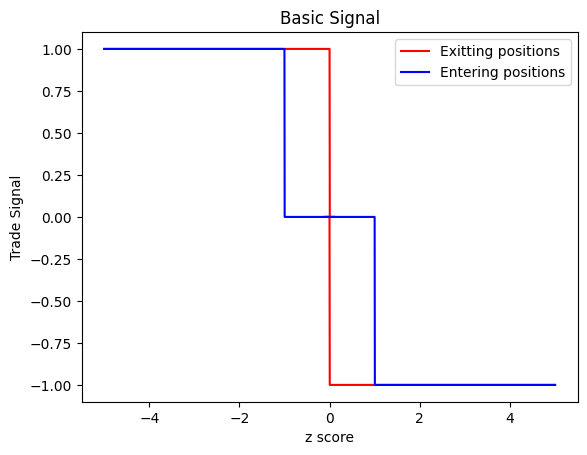

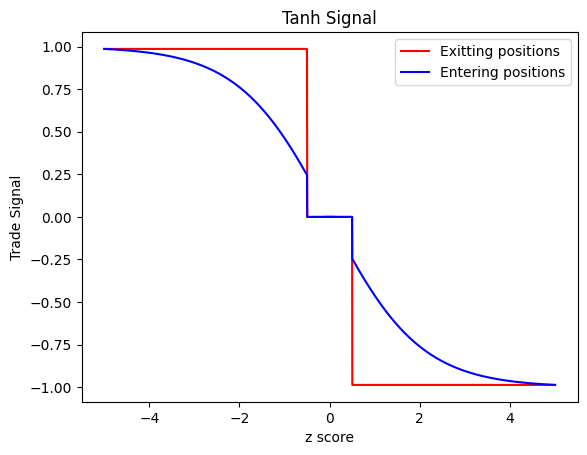

In [12]:
x_scores_entering = np.linspace(.1, -5, 1000)
x_scores_entering_2 = np.linspace(-.1, 5, 1000)
x_scores_exitting = np.linspace(-5, .1, 1000)
x_scores_exitting_2 = np.linspace(5, -.1, 1000)


def basic_signal(z_score_array, z_score_trigger_in = 1, z_score_trigger_out = 0):
  signal = np.zeros(len(z_score_array))
  entered_long = False
  entered_short = False

  for i, element in enumerate(z_score_array):

    if not entered_long and not entered_short and element > z_score_trigger_in:
        signal[i] = -1
        entered_short = True

    elif not entered_long and not entered_short and element < -z_score_trigger_in:
      signal[i] = 1
      entered_long = True

    elif element > -z_score_trigger_out and entered_long:
      signal[i] = 0
      entered_long = False

    elif element < z_score_trigger_out and entered_short:
      signal[i] = 0
      entered_short = False

    else:
      if i == 0:
        signal[i] = 0
      else:
        signal[i] = signal[i-1]

  return signal

# plt.plot(x_scores, basic_signal(x_scores), label = "Entering positions")

plt.plot(x_scores_exitting, basic_signal(x_scores_exitting), label = "Exitting positions",c =  "r")
plt.plot(x_scores_exitting_2, basic_signal(x_scores_exitting_2), c = "r")
plt.plot(x_scores_entering, basic_signal(x_scores_entering), label = "Entering positions",c =  "b")
plt.plot(x_scores_entering_2, basic_signal(x_scores_entering_2), c = "b")
plt.xlabel("z score")
plt.ylabel("Trade Signal")
plt.legend()
plt.title("Basic Signal")
plt.show()



def tanh_signal(z_score_array, z_score_scaling = 2, z_score_trigger = 0.5):
  signal = np.zeros(len(z_score_array))
  entered_long = False
  entered_short = False
  for i, element in enumerate(z_score_array):
    if not entered_long and not entered_short and element > z_score_trigger:
        signal[i] = -np.tanh(element/z_score_scaling)
        entered_short = True

    elif not entered_long and not entered_short and element < -z_score_trigger:
      signal[i] = -np.tanh(element/z_score_scaling)
      entered_long = True

    elif element > -z_score_trigger and entered_long:
      signal[i] = 0
      entered_long = False

    elif element < z_score_trigger and entered_short:
      signal[i] = 0
      entered_short = False

    else:
      if i == 0:
        signal[i] = 0
      elif entered_short:
        signal[i] = min([signal[i-1], -np.tanh(element/z_score_scaling)])
      elif entered_long:
        signal[i] = max([signal[i-1], -np.tanh(element/z_score_scaling)])
      else:
        signal[i] = 0

  return signal


plt.plot(x_scores_exitting, tanh_signal(x_scores_exitting), label = "Exitting positions",c =  "r")
plt.plot(x_scores_exitting_2, tanh_signal(x_scores_exitting_2), c = "r")
plt.plot(x_scores_entering, tanh_signal(x_scores_entering), label = "Entering positions",c =  "b")
plt.plot(x_scores_entering_2, tanh_signal(x_scores_entering_2), c = "b")
plt.xlabel("z score")
plt.legend()
plt.ylabel("Trade Signal")
plt.title("Tanh Signal")
plt.show()

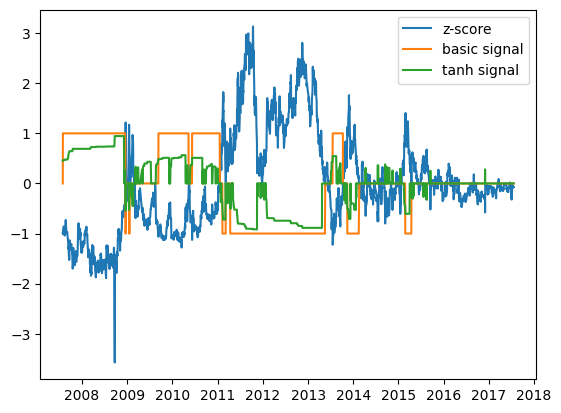

In [13]:
plt.plot(train.index, train_z_score, label = "z-score")
plt.plot(train.index, basic_signal(train_z_score), label = "basic signal")
plt.plot(train.index, tanh_signal(train_z_score), label = "tanh signal")
plt.legend()
plt.show()

#Backtest Functions + Strategy Assessment

## **backtest** Here are a couple more freebie functions, the first is a backtest function that takes in a pair of time series, and the trade signal generated each day (without shifting - in practice we have to shift the signal by 1 so that day 1's signal affects the returns of the strategy on day1->day2).

##It also has an optional parameter *cumulative_returns* which when True, shows how much money you'd make on $100 historically with this strategy, or returns the daily % pnl if False.

## **create_test_zscores** Here are a couple more freebie functions, the first is a backtest function that takes in a pair of time series, and the trade signal generated each day (without shifting - in practice we have to shift the signal by 1 so that day 1's signal affects the returns of the strategy on day1->day2).

##It also has an optional parameter *cumulative_returns* which, if True, shows how much money you'd make on $100 historically with this strategy (with compounding), or returns the daily % pnl if False.

## **calc_sharpe** This computes the sharpe ratio (with a r.f.r of 0 (dubious I know)) but allows you to compare the risk adjusted return of the two strategies. You should input the daily_percent_returns without compounding (*cumulative_returns* = False)

In [14]:
def backtest(pair_time_series, unshifted_signal, cumulative_returns = True):
  asset_1 = pair_time_series.iloc[:,0]
  asset_2 = pair_time_series.iloc[:,1]

  change_in_price_asset_1 = asset_1.diff()
  change_in_price_asset_1[0] = 0
  change_in_price_asset_2 = asset_2.diff()
  change_in_price_asset_2[0] = 0

  signal_asset_1 = -unshifted_signal*gradient
  signal_asset_2 = unshifted_signal

  shifted_signal_asset_1 = np.roll(signal_asset_1,1)
  shifted_signal_asset_1[0] = 0


  shifted_signal_asset_2 = np.roll(signal_asset_2,1)
  shifted_signal_asset_2[0] = 0


  daily_returns_asset_1 = change_in_price_asset_1*shifted_signal_asset_1
  daily_returns_asset_2 = change_in_price_asset_2*shifted_signal_asset_2

  daily_returns = daily_returns_asset_1 + daily_returns_asset_2

  total_holdings = asset_1 + asset_2/gradient

  daily_percentage_returns = daily_returns/total_holdings

  if cumulative_returns:
    cumulative_pct_returns = 100*np.cumprod(1+daily_percentage_returns)
    return cumulative_pct_returns

  else:
    return daily_percentage_returns

def create_test_z_scores(pair_time_series = test):
  asset_1 = pair_time_series.iloc[:,0]
  asset_2 = pair_time_series.iloc[:,1]

  residual = asset_2 - (gradient*asset_1+intercept)

  test_z_score = (residual - train_residual.mean())/train_residual.std()

  return test_z_score

def calc_sharpe(non_cumulative_return_time_series):
  mean_daily_return = np.mean(non_cumulative_return_time_series)
  mean_yearly_return = 252*mean_daily_return
  volatility_of_returns = np.std(non_cumulative_return_time_series)
  print(mean_yearly_return, volatility_of_returns)
  return (mean_yearly_return)/(np.sqrt(252)*volatility_of_returns)


# Strategy Comparison (1 mark)

##Using the functions provided, assess the performance of both the Basic & Tanh strategies **for the train portion of our dataset** (train), which strategy is better and why? Is this still true on the test data

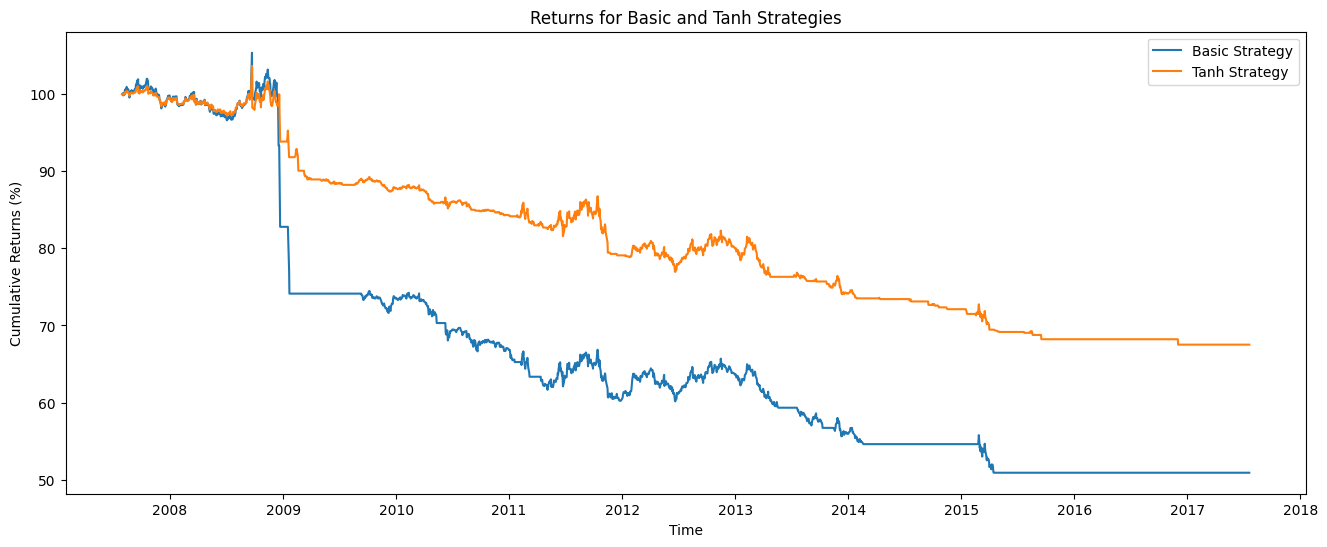

-0.06623076717637827 0.004841779798180418
Basic Sharpe Ratio is:  -0.8616968021492223
-0.039006639362102455 0.0031817332511957677
Tanh Sharpe Ratio is:  -0.7722794845030473


In [15]:
#Backtest + Evaluate here
basic_signal_result = basic_signal(train_z_score)
basic_backtest_result = backtest(train, basic_signal_result)

tanh_signal_result = tanh_signal(train_z_score)
tanh_backtest_result = backtest(train, tanh_signal_result)

plt.figure(figsize=(16, 6))
plt.plot(basic_backtest_result, label='Basic Strategy')
plt.plot(tanh_backtest_result, label='Tanh Strategy')
plt.title('Returns for Basic and Tanh Strategies')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns (%)')
plt.legend()
plt.show()


#Calculating Sharpe Ratio's
basic_backtest_result_sharpe = backtest(train,basic_signal_result,cumulative_returns = False)
print("Basic Sharpe Ratio is: ",calc_sharpe(basic_backtest_result_sharpe))

tanh_backtest_result_sharpe = backtest(train,tanh_signal_result,cumulative_returns = False)
print("Tanh Sharpe Ratio is: ",calc_sharpe(tanh_backtest_result_sharpe))

In [16]:
Better_Strategy = "Tanh" #Replace the RHS Tanh or Basic
B_S_Sharpe_Ratio = -0.77 #Replace the RHS
True_or_False = "True"
print(Better_Strategy, B_S_Sharpe_Ratio)
print("Is it true for the test data: ", True_or_False)

Tanh -0.77
Is it true for the test data:  True


#Tanh Strategy Optimisation (2 marks)

##**To 1 decimal place**, what is the best value for the "z_score_scaling" parameter between 0.5 and 3 (optimise using the train z_score and keep other parameters fixed). When using the parameter, what is its corresponding sharpe on a) train and b) test.

## An easy way to do this is to loop through the parameter and look at the sharpe for each of value, maximmise the sharpe.

In [17]:
#Calculate it here
max_sharpe = float("-inf")
optimal_z_score_scaling = 2
for i in range(1000):
    tanh_signal_result = tanh_signal(train_z_score,z_score_scaling = 0.5+i*(2.5/1000))
    tanh_backtest_result_sharpe = backtest(train,tanh_signal_result,cumulative_returns = False)
    sharpe = calc_sharpe(tanh_backtest_result_sharpe)
    if sharpe>max_sharpe:
        max_sharpe = sharpe
        optimal_z_score_scaling = 0.5+i*(2.5/1000)
print(optimal_z_score_scaling) # Ignore the all the data printed before the final line

-0.06258579568395735 0.0048260833162899605
-0.06254625972256209 0.004823829452588888
-0.06250658134117265 0.00482156303502426
-0.062466762254108354 0.004819284168762975
-0.06242680416360954 0.004816992958948068
-0.062386708760006696 0.004814689510685323
-0.06234647772188592 0.004812373929030194
-0.06230611271624975 0.0048100463189750245
-0.06226561539867413 0.0048077067854365605
-0.06222498741346106 0.004805355433243745
-0.062184230393786726 0.004802992367125782
-0.06214334596184586 0.004800617691700486
-0.06210233572899135 0.0047982315114628625
-0.0620612012958699 0.004795833930773964
-0.062019944252553416 0.004793425053849984
-0.061978566178666185 0.004791004984751589
-0.061937068643507814 0.004788573827373484
-0.061895453206172256 0.00478613168543421
-0.06185372141566256 0.004783678662466156
-0.06181187481100183 0.004781214861805799
-0.06176991492133996 0.004778740386584142
-0.06172784326605685 0.004776255339717375
-0.06168566135486142 0.004773759823897721
-0.06164337068788729 0.004

In [21]:
optimum_z_score_scaling = 2.9975 # result from previous cell

tanh_signal_result_optimal = tanh_signal(train_z_score,z_score_scaling = 2.9975)
tanh_backtest_result_sharpe_optimal = backtest(train,tanh_signal_result_optimal,cumulative_returns = False)


sharpe_train = calc_sharpe(tanh_backtest_result_sharpe_optimal)
print(optimum_z_score_scaling, sharpe_train) # Only look at final line

-0.030042406515853173 0.0024800255823583576
2.9975 -0.7630944365699863


# Bonus Mark! Suggest a different pair of assets that you think might be cointegrated + appropiate for pairs trading and why do you think this? (+1 mark)

I think Visa (V) and Mastercard (MA) are cointegrated and are appropriate for pairs trading.  This is because the two companies are the largest in payment processing, and have a similar business model and are affected by similar market conditions. The two companies are effictively a duopoly, and may exhibit mean-reverting behaviour.